In [1]:
#objective of this video is to put dataset into tf pipeline and then cleaing
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE =256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS =2

In [3]:
#do watch tf dataset pipeline video
#below we have loaded the dataset through tensorflow
dataset = tf.keras.preprocessing.image_dataset_from_directory("data",
                                                   shuffle = True,
                                                 image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Crop___Early_blight', 'Crop___Late_blight', 'Crop___healthy']

In [5]:
#68 becoz images is a batch of 32 batches 
len(dataset)

68

In [6]:
#exploring the dataset only matlab information le rahe dataset ki
#below line will give us the 1 batch
for image_batch ,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
#0 for Potato___Early_blight   1 for  'Potato___Late_blight   2 for 'Potato___healthy

(32, 256, 256, 3)
[0 2 0 0 2 1 0 0 1 2 1 0 0 1 1 0 0 0 0 1 1 2 0 0 2 0 1 1 0 0 2 1]


In [7]:
#if i want to print first image
for image_batch ,label_batch in dataset.take(1):
    print(image_batch[0])
    #output will be tensor so use numpy and it will be 3D

tf.Tensor(
[[[159. 149. 157.]
  [144. 134. 142.]
  [145. 135. 143.]
  ...
  [133. 122. 126.]
  [128. 117. 121.]
  [120. 109. 113.]]

 [[161. 151. 159.]
  [156. 146. 154.]
  [162. 152. 160.]
  ...
  [131. 120. 124.]
  [129. 118. 122.]
  [122. 111. 115.]]

 [[155. 145. 153.]
  [156. 146. 154.]
  [165. 155. 163.]
  ...
  [129. 118. 122.]
  [130. 119. 123.]
  [127. 116. 120.]]

 ...

 [[179. 167. 167.]
  [180. 168. 168.]
  [182. 170. 170.]
  ...
  [177. 163. 163.]
  [149. 135. 135.]
  [148. 134. 134.]]

 [[182. 170. 170.]
  [181. 169. 169.]
  [181. 169. 169.]
  ...
  [151. 137. 137.]
  [158. 144. 144.]
  [153. 139. 139.]]

 [[190. 178. 178.]
  [188. 176. 176.]
  [185. 173. 173.]
  ...
  [129. 115. 115.]
  [146. 132. 132.]
  [114. 100. 100.]]], shape=(256, 256, 3), dtype=float32)


# visulising the images

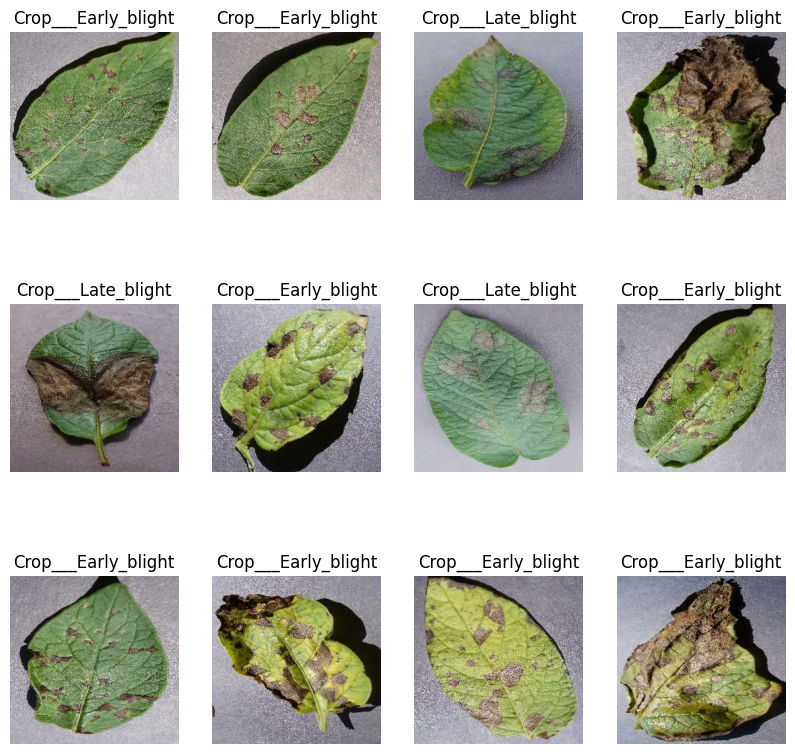

In [8]:
#visualising the images
plt.figure(figsize = (10,10))
for image_batch ,label_batch in dataset.take(1):
    #bhuut saari images dikhane k liye
    for i in range(12):
        ax =  plt.subplot(3,4,i+1)
    #plt.imshow expects a 3D array as parameter
        plt.imshow(image_batch[i].numpy().astype("uint8"))
    #label dene k liye ki konsi image hai ye below
        plt.title(class_names[label_batch[i]])
    #axis pe jo number aatey hai unko hide karne k liye below
        plt.axis("off")
     
   

# Train Test split

In [9]:
# #split into training and testing
# 80%==> training
# 20%==> 10% validation,10% testing

In [10]:
#yha humne nikala ki total datset k andar 80 % kitna hua then utne images le liye
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [11]:
#niche wali line 54 bathes le legi
train_ds =dataset.take(54)


In [12]:
#slicing : wali ki tarh ,yaani pehli 54 ko chhod do and baaki lelo
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
#all we did upar we are not doing that all in a function
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,shuffle = True,shuffle_size =10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds  =   ds.skip(train_size).take(val_size)
    test_ds  =  ds.skip(train_size).skip(val_size)
    return train_ds, val_ds,test_ds 

In [16]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
#caching kar rahe hai jise ki next time bar bar image ko na dhoondna pade
#optimise kar diye thode se for training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Now some preprocessing

In [21]:
#applying normalisation and rescaling
#resizing becoz becoz agar humne training k dauran koi badi size ki image
#pass kardi then it will take care of it
#resize_and_rescale all these are layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
#applying data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

# Build Model

In [23]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes =3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
     layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])
model.build(input_shape = input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [25]:
model.compile(
optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
metrics = ['accuracy'])

In [26]:
history = model.fit(train_ds,
         epochs = EPOCHS,
        batch_size = BATCH_SIZE,
          #verbose to print multiple outputs so that we can know what is going on
         verbose =1,
         validation_data = val_ds )

Epoch 1/2
54/54 [==============================] - 136s 2s/step - loss: 0.9404 - accuracy: 0.4728 - val_loss: 0.9316 - val_accuracy: 0.5382
Epoch 2/2
54/54 [==============================] - 112s 2s/step - loss: 0.8495 - accuracy: 0.5619 - val_loss: 0.6993 - val_accuracy: 0.6869


In [27]:
scores = model.evaluate(test_ds)

54/54 [==============================] - 14s 265ms/step - loss: 0.6993 - accuracy: 0.6869


In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
len(history.history['accuracy'])

2

In [32]:
#accuracy store karke rakhta hai
history.history['accuracy']

[0.47280094027519226, 0.5619212985038757]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation Loss')

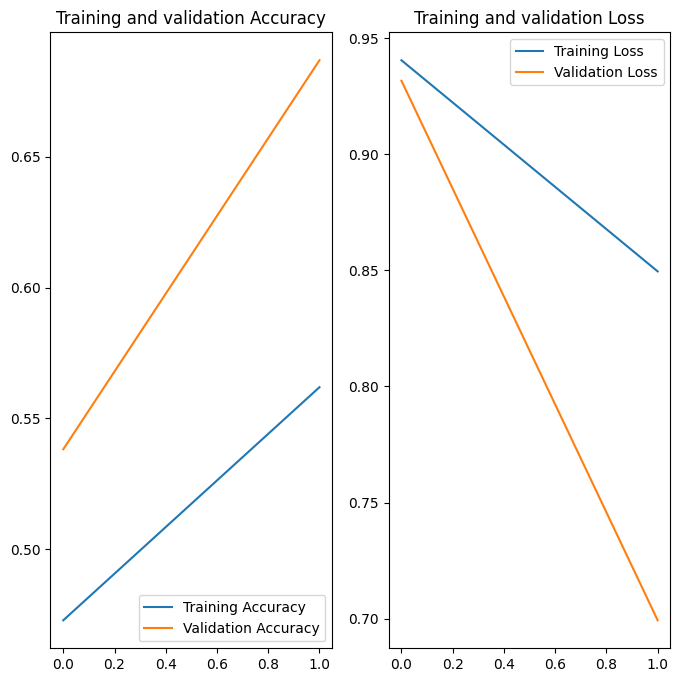

In [34]:
#to improve the accuracy increase the no.of epochs
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation Loss')

first image to predict
first image's actual label Crop___Early_blight
1/1 [==============================] - 1s 589ms/step
[9.7429490e-01 2.5570925e-02 1.3416320e-04]


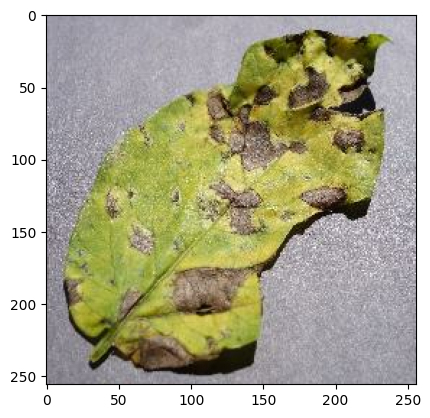

In [35]:
for images_batch,labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label" , class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])

In [36]:
#function taking model and image as input and telling us the predicted class and accuracy
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)#create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


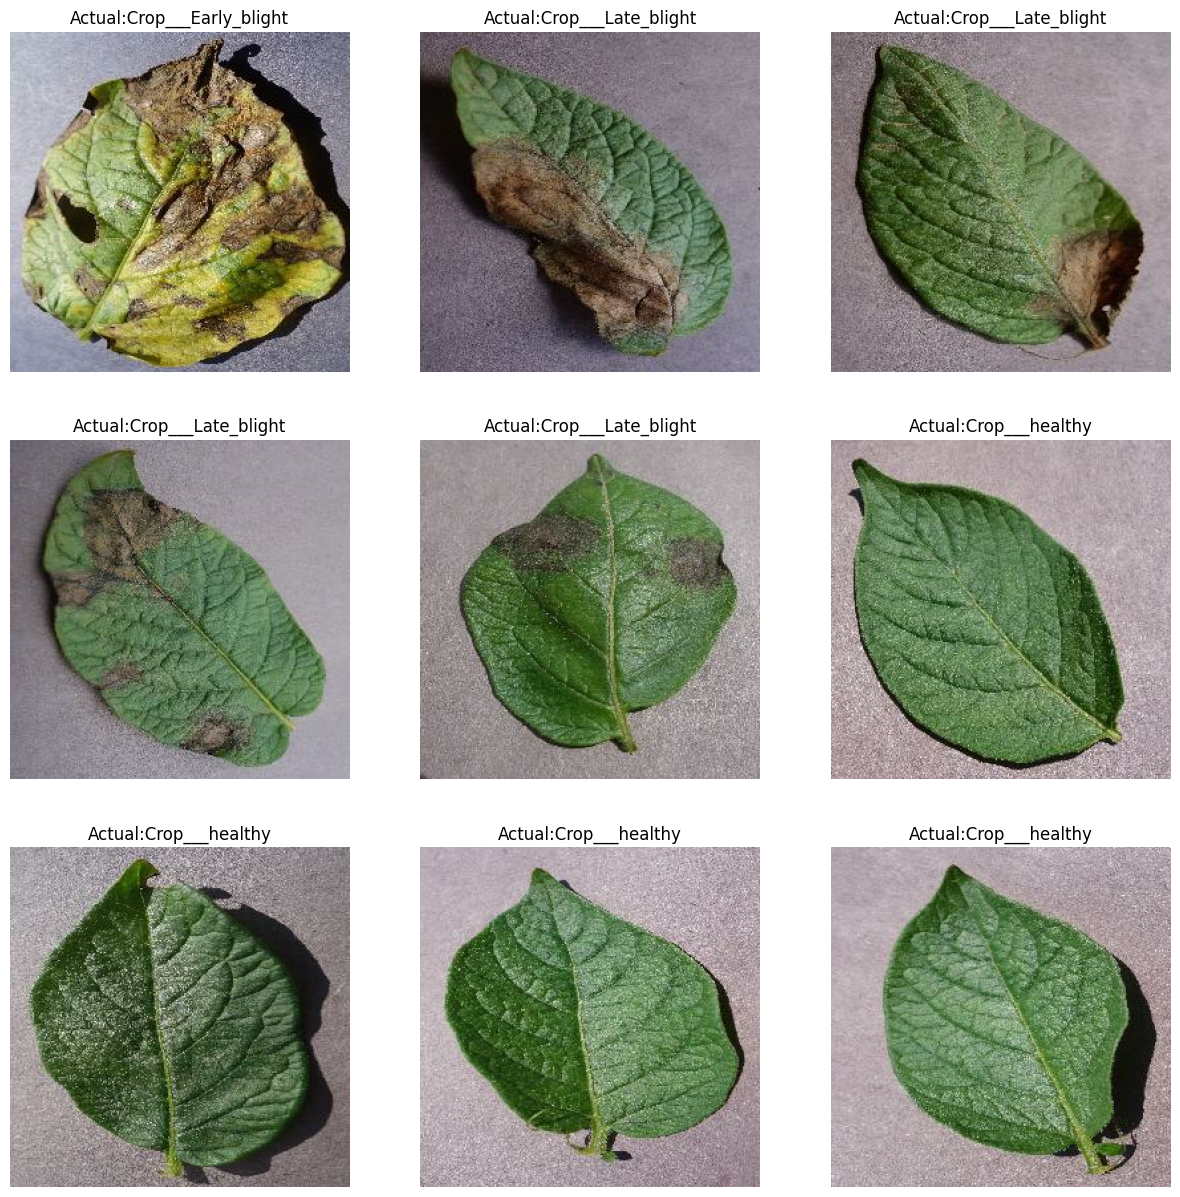

In [37]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class}")
        plt.axis("off")
        

In [38]:
model.save('crop_disease_model.h5')

In [39]:
#this is how tensorflow models are saved firstly make a folder in home page
#and then run the belwo command
model_version =1
model.save(f"./Model/{model_version}")

INFO:tensorflow:Assets written to: ./Model/1\assets


INFO:tensorflow:Assets written to: ./Model/1\assets
